<a href="https://colab.research.google.com/github/Kko-projects/deeplearning-w-pytorch/blob/main/08a_cifar10_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
print(torch.cuda.is_available())  # Should print True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

from torchsummary import summary
from tqdm import tqdm

True


2. Environment & Hyperparameters

In [3]:
#Global Variable For training
Batch_Size=100
Num_Epoch=2
Learning_Rate=0.01
Criterion=nn.CrossEntropyLoss()
Optimizer=torch.optim.Adam

3. Load CIFAR-10 Dataset

In [4]:
#CIFARIO Dataset
Train_dataset=dsets.CIFAR10(root='./data',train=True,transform=transforms.ToTensor(),download=True)
Test_dataset=dsets.CIFAR10(root='./data',train=False,transform=transforms.ToTensor(),download=True)

Train_loader=DataLoader(dataset=Train_dataset,batch_size=Batch_Size,shuffle=True)
Test_loader=DataLoader(dataset=Test_dataset,batch_size=Batch_Size,shuffle=False)


100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


4. Visualize a Few Images

In [5]:
Train_dataset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [6]:
Train_dataset[0][0].shape

torch.Size([3, 32, 32])

In [7]:
Train_dataset.targets[0]

6

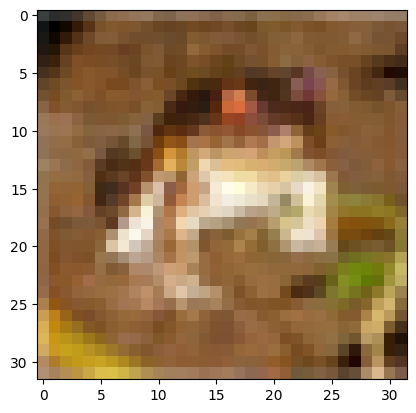

In [8]:
plt.imshow(Train_dataset[0][0].permute(1,2,0))

frog


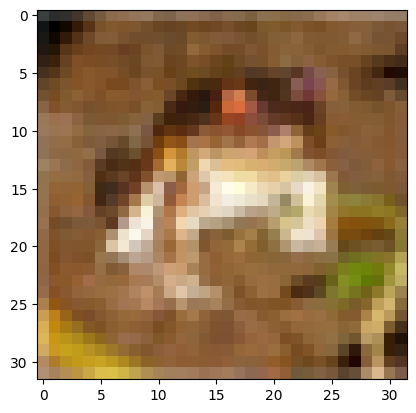

In [9]:
index=0
print(Train_dataset.classes[Train_dataset.targets[index]])
plt.imshow(Train_dataset[index][0].permute(1,2,0))

truck


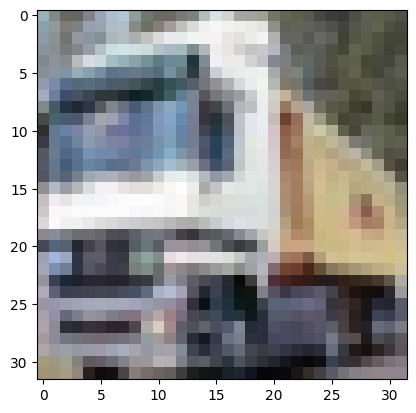

In [10]:
index=1
print(Train_dataset.classes[Train_dataset.targets[index]])
plt.imshow(Train_dataset[index][0].permute(1,2,0))

truck


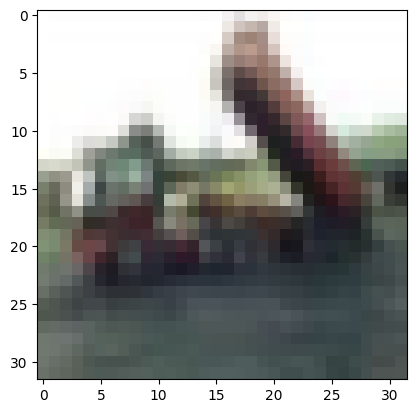

In [11]:
index=2
print(Train_dataset.classes[Train_dataset.targets[index]])
plt.imshow(Train_dataset[index][0].permute(1,2,0))

4
deer


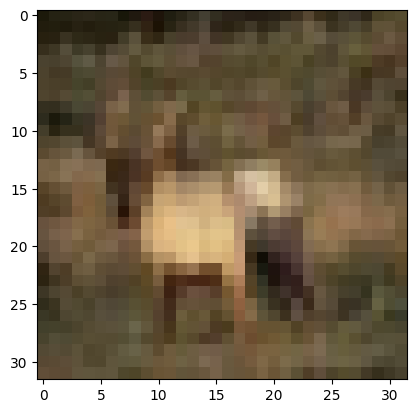

In [12]:
index=3
print(Train_dataset.targets[index])
print(Train_dataset.classes[Train_dataset.targets[index]])
plt.imshow(Train_dataset[index][0].permute(1,2,0))

5. Define Training and Evaluation Functions

In [13]:
def fit(model,train_loader):
  model.train()
  device = next(model.parameters()).device.index
  optimizer = torch.optim.SGD(model.parameters(), lr=Learning_Rate, momentum=0.9)
  losses = []
  for i, data in enumerate(train_loader):
    image= data[0].type(torch.FloatTensor).cuda(device)
    label= data[1].type(torch.LongTensor).cuda(device)

    pred = model(image)                 # Forward pass
    loss = Criterion(pred, label)       # Compute loss
    optimizer.zero_grad()              # Clear gradients
    loss.backward()                    # Backpropagation
    optimizer.step()                   # Update weights

    losses.append(loss.item())         # Save loss for tracking

  avg_loss = sum(losses)/len(losses)  # Return average loss
  return avg_loss

In [14]:
def eval(model, Test_loader):
  model.eval()
  device = next(model.parameters()).device.index  # Get the device (GPU/CPU) model is on
  pred_labels = []
  real_labels = []

  for i, data in enumerate(Test_loader):
    image = data[0].type(torch.FloatTensor).cuda(device)  # Move image to the correct device
    label = data[1].type(torch.LongTensor).cuda(device)   # Move label to the correct device

    real_labels += label.tolist() # Save ground-truth labels
    pred_label = model(image)  # Get raw output from model (logits)
    pred_label = torch.argmax(pred_label, dim=1)  # Get predicted class (index of max logit)
    pred_labels += pred_label.tolist()  # Save predictions


  # Convert to numpy arrays for easier comparison
  real_labels = np.array(real_labels)
  pred_labels = np.array(pred_labels)

  # Calculate accuracy: how many predictions matched the actual labels
  accuracy = sum(real_labels == pred_labels)/len(real_labels)*100

  return accuracy # Return percentage accuracy

6. Define Simple MLP

In [15]:
# MLP Structure : fully connected layer + reshape + pooling
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()

        # First fully connected layer: flatten 3x32x32 image to vector, output 8x24x24 feature size
        self.fc1 = nn.Linear(3*32*32, 8*24*24)
        self.relu1 = nn.ReLU()

        # Second fully connected layer (same output shape to maintain compatibility)
        self.fc2 = nn.Linear(8*24*24, 8*24*24)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)  # Downsampling layer (2x2)

        # Third FC layer after pooling: output 16x8x8 features
        self.fc3 = nn.Linear(8*12*12, 16*8*8)
        self.relu3 = nn.ReLU()

        # Fourth FC layer: output 16x4x4 features
        self.fc4 = nn.Linear(16*8*8, 16*4*4)
        self.relu4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)  # Downsampling again

        # Final output layer: flatten and output scores for 10 classes
        self.out = nn.Linear(16*2*2, 10)



    def forward(self, x):
        # Flatten input image from (batch_size, 3, 32, 32) to (batch_size, 3*32*32)
        x = x.view(-1, 3*32*32)

        # Pass through first FC layer and activation
        x = self.relu1(self.fc1(x))

        # Second FC layer and activation
        x = self.relu2(self.fc2(x))

        # Reshape to 3D feature map for pooling: (batch_size, 8, 24, 24)
        x = x.view(-1, 8, 24, 24)

        # Max pooling: output becomes (batch_size, 8, 12, 12)
        x = self.pool1(x)

        # Flatten for FC again: (batch_size, 8*12*12)
        x = x.view(-1, 8*12*12)

        # Third FC layer and activation
        x = self.relu3(self.fc3(x))

        # Fourth FC layer and activation
        x = self.relu4(self.fc4(x))

        # Reshape to 3D again: (batch_size, 16, 4, 4)
        x = x.view(-1, 16, 4, 4)

        # Second pooling: becomes (batch_size, 16, 2, 2)
        x = self.pool2(x)

        # Flatten for output layer: (batch_size, 16*2*2)
        x = x.view(-1, 16*2*2)

        # Final output: (batch_size, 10) – raw class scores (logits)
        out = self.out(x)

        return out



Debug Note: Shape Mismatch in SimpleMLP

When running the model, I encountered the following error:
RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x4608 and 6272x4608)

The shape mismatch was caused by incorrect input dimensions in the second linear layer (fc2).
The first linear layer (fc1) outputs a tensor of shape [batch_size, 8*24*24], but fc2 was incorrectly expecting an input of shape [batch_size, 8*28*28].

I updated fc2 to match the correct input shape: self.fc2 = nn.Linear(8*24*24, 8*24*24)

This resolved the shape mismatch error.



7. Train and Evaluate MLP

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instantiate the model and move it to GPU
mlp_model = SimpleMLP().to(device)

train_loss1=[]  # To store training loss after each epoch
test_acc1=[]   # To store test accuracy after each epoch

# Training loop
for epoch in tqdm(range(Num_Epoch)):  # Loop through each epoch
    loss = fit(mlp_model, Train_loader)      # Train model and get average loss
    acc = eval(mlp_model, Test_loader)       # Evaluate on test set and get accuracy
    train_loss1.append(loss)                 # Save loss
    test_acc1.append(acc)                    # Save accuracy


summary(mlp_model,(3,32,32)) # Input shape = (channels, height, width)


100%|██████████| 2/2 [00:26<00:00, 13.24s/it]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4608]      14,160,384
              ReLU-2                 [-1, 4608]               0
            Linear-3                 [-1, 4608]      21,238,272
              ReLU-4                 [-1, 4608]               0
         MaxPool2d-5            [-1, 8, 12, 12]               0
            Linear-6                 [-1, 1024]       1,180,672
              ReLU-7                 [-1, 1024]               0
            Linear-8                  [-1, 256]         262,400
              ReLU-9                  [-1, 256]               0
        MaxPool2d-10             [-1, 16, 2, 2]               0
           Linear-11                   [-1, 10]             650
Total params: 36,842,378
Trainable params: 36,842,378
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Fo

In [17]:
train_loss1, test_acc1

([1.9563250710964204, 1.692777741909027],
 [np.float64(36.919999999999995), np.float64(40.699999999999996)])

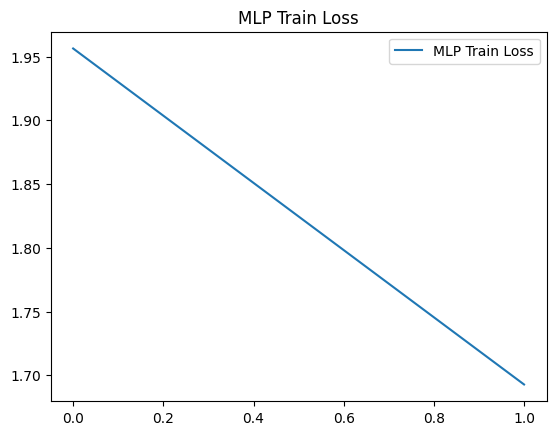

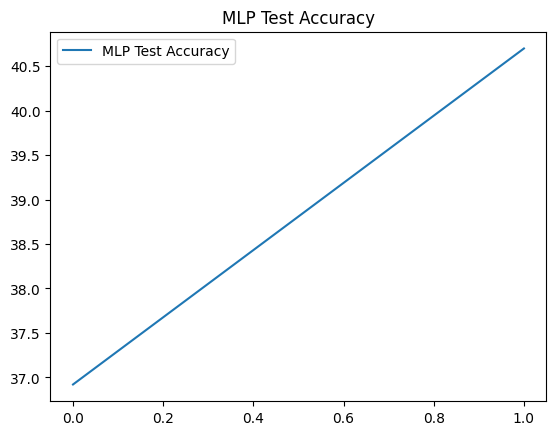

In [18]:
plt.plot(train_loss1, label='MLP Train Loss')
plt.legend()
plt.title('MLP Train Loss')
plt.show()

plt.plot(test_acc1, label='MLP Test Accuracy')
plt.legend()
plt.title('MLP Test Accuracy')
plt.show()